# Try to fetch information from statistics.gov.scot using SPARQL

[statistics.gov.scot](http://statistics.gov.scot) makes many useful datasets available as linked open data.

Let's execute a [SPARL](https://www.w3.org/TR/sparql11-query/) query to retrive information about all of those datssets...


In [3]:
; Add code libraries 

%classpath add mvn org.clojure data.csv 1.0.0
(require '[clojure.data.csv :as csv])

%classpath add mvn clj-http clj-http 3.10.1
(require '[clj-http.client :as http])

(require '[clojure.string :as str])

(import 'java.net.URLEncoder)
(import 'java.time.LocalDate)
(import 'com.twosigma.beakerx.chart.xychart.TimePlot
        'com.twosigma.beakerx.chart.xychart.plotitem.Line)

class com.twosigma.beakerx.chart.xychart.plotitem.Line

In [4]:
; Define convenience functions

; Convert the CSV structure to a list-of-maps structure.
(defn to-maps [csv-data]
    (map zipmap (->> (first csv-data)
                    (map keyword)
                    repeat)
                (rest csv-data)))

; Ask statistic.gov.scot to execute the given SPARQL query
; and return its result as a list-of-maps.
(defn exec-query [sparql]
    (->> (http/post "http://statistics.gov.scot/sparql" 
                    {:body (str "query=" (URLEncoder/encode sparql)) 
                    :headers {"Accept" "text/csv" 
                              "Content-Type" "application/x-www-form-urlencoded"} 
                    :debug false})
        :body
        csv/read-csv
        to-maps))

#'beaker_clojure_shell_d969f8d8-804b-4a28-a997-e83a4343705f/exec-query

In [5]:
; Query for information about all the datasets

(def sparql "

PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT ?dataset ?name ?publisherLabel

WHERE {
    ?dataset rdf:type <http://publishmydata.com/def/dataset#Dataset>.
    ?dataset rdfs:label ?name.
    ?dataset dcterms:publisher ?publisher.

    ?publisher rdfs:label ?publisherLabel.
}
")

(def all-datasets (exec-query sparql))

(str (count all-datasets) " datasets")

290 datasets

My [previous report](https://stir.sharepoint.com/:w:/r/sites/DataCommonsScotland/_layouts/15/Doc.aspx?sourcedoc=%7B5DD2D579-68D4-4C21-91CD-CCF6BE8BC276%7D&file=2020-04-16-progress-report-ash.docx&action=default&mobileredirect=true) used the Household Waste dataset from SEPA and the Population dataset from NRS.

Let's find those two datasets in the statistics.gov.scot information...


In [6]:
; Filter to find SEPA's Household Waste and NRS' Population datasets

(->> all-datasets
    (filter #(or 
                (and (= "SEPA" (:publisherLabel %)) 
                     (str/includes? (:name %) "Household Waste"))
                (and (= "National Records of Scotland" (:publisherLabel %)) 
                     (str/includes? (:name %) "Population")
                     (str/includes? (:name %) "Current"))))
    (sort-by :name))

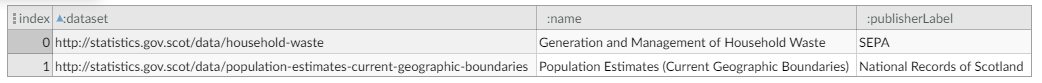

Within [this](https://github.com/ash-mcc/dcs/blob/master/linked-data-experiment/plot-info-graphics.ipynb) previous lab book, we queried its triplestore for the waste tonnage genearated per council citizen per year by executing the [Datalog](https://en.wikipedia.org/wiki/Datalog) query:
```
          [:find ?c ?y ?t2 :where                       ; return council, year & tonnage
            [?e1 :waste-type/name "Subtotal"]            
            [?e2 :waste-process/name "Generated"]       
            [?e3 :waste-tonnes-cytp/waste-type ?e1]     ; fixed at Subtotal
            [?e3 :waste-tonnes-cytp/waste-process ?e2]  ; fixed at Generated
            [?e3 :waste-tonnes-cytp/tonnes ?t1]         ; tonnage for a council for a year
            [?e3 :waste-tonnes-cytp/council ?e4]
            [?e3 :waste-tonnes-cytp/year ?e5]
            [?e4 :council/name ?c]                      ; used to join waste- & population- facts
            [?e5 :year/value ?y]                        ; used to join waste- & population- facts
            [?e6 :population-cy/council ?e4]
            [?e6 :population-cy/year ?e5]
            [?e6 :population-cy/population ?p]          ; population for a council for a year 
            [(/ ?t1 ?p) ?t2]]                           ; calculate the tonnage per citizen
```

In theory, we ought to be able to acheive the same result by executing an equivalent SPARQL query against the datasets held in statistic.gov.scot. <br/>
Let's try building up such a query step-by-step...


In [7]:
; Query for the waste tonnage genearated per council per year

(def sparql "

PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX pdmx: <http://purl.org/linked-data/sdmx/2009/dimension#>
PREFIX sdmx: <http://statistics.gov.scot/def/dimension/>
PREFIX snum: <http://statistics.gov.scot/def/measure-properties/>

SELECT ?c ?y ?t
WHERE {
  
    ?tonnage qb:dataSet <http://statistics.gov.scot/data/household-waste> .
    ?tonnage pdmx:refArea ?area .
    ?tonnage pdmx:refPeriod ?period .
    ?tonnage sdmx:wasteCategory ?wastecategory .
    ?tonnage sdmx:wasteManagement ?wastemanagement .
    ?tonnage snum:count ?t .
    ?area rdfs:label ?c .
    ?period rdfs:label ?y .
  
    ?wastecategory rdfs:label \"Total Waste\" .
    ?wastemanagement rdfs:label \"Waste Generated\" .
}
")

(def tonnage-generated-per-council-per-year (exec-query sparql))

(sort-by (juxt :c :y) tonnage-generated-per-council-per-year)

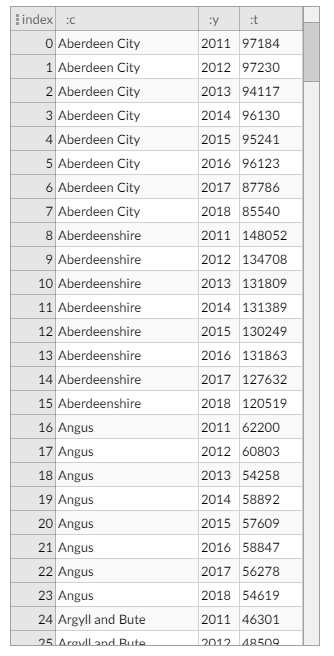

In [8]:
; Query for the population per council per year (attempt #1)

(def sparql "

PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX pdmx: <http://purl.org/linked-data/sdmx/2009/dimension#>
PREFIX sdmx: <http://statistics.gov.scot/def/dimension/>
PREFIX snum: <http://statistics.gov.scot/def/measure-properties/>
PREFIX uent: <http://statistics.data.gov.uk/def/statistical-entity#>

SELECT ?c ?y ?p
WHERE {

    ?population qb:dataSet <http://statistics.gov.scot/data/population-estimates-current-geographic-boundaries> .
    ?population pdmx:refArea ?area .
    ?population pdmx:refPeriod ?period .
    ?population sdmx:age ?age .
    ?population sdmx:sex ?sex .
    ?population snum:count ?p .
  
    ?area rdfs:label ?c .
    ?area uent:code ?y .
    ?period rdfs:label ?periodLabel .
  
    ?areaCode rdfs:label \"Council Areas\" .
    ?age rdfs:label \"All\" .
    ?sex rdfs:label \"All\" .
    
    VALUES ?periodLabel {\"2011\" \"2012\" \"2013\" \"2014\" \"2015\" \"2016\" \"2017\" \"2018\"}
}
")

#'beaker_clojure_shell_d969f8d8-804b-4a28-a997-e83a4343705f/sparql

But statistics.gov.scot fails (with a timeout error message) when the above SPARQL query is executed against it. 

Bill Roberts (from Swirrl IT whose PublishMyData platform underlies the statistics.gov.scot site) helped me figure out the root cause of the failure: 
basically, that query results in too many _joins_ to compute within the 30 seconds limit of their public SPARQL endpoint. 
Bill suggested replacing `label`s with 'fixed' facts and performing the `VALUES` filter outside of SPARQL. 

So lets's try again...


In [9]:
; Query for the population per council per year (attempt #2)

(def sparql "

PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX pdmx: <http://purl.org/linked-data/sdmx/2009/dimension#>
PREFIX sdmx: <http://statistics.gov.scot/def/dimension/>
PREFIX snum: <http://statistics.gov.scot/def/measure-properties/>
PREFIX uent: <http://statistics.data.gov.uk/def/statistical-entity#>

SELECT ?c ?y ?p
WHERE {

    ?population qb:dataSet <http://statistics.gov.scot/data/population-estimates-current-geographic-boundaries> .
    ?population pdmx:refArea ?area .
    ?population pdmx:refPeriod ?period .
    ?population sdmx:age <http://statistics.gov.scot/def/concept/age/all> .
    ?population sdmx:sex <http://statistics.gov.scot/def/concept/sex/all> .
    ?population snum:count ?p .

    ?area uent:code <http://statistics.gov.scot/id/statistical-entity/S12> .
    ?area rdfs:label ?c .
    ?period rdfs:label ?y .
}
")

(def population-per-council-per-year 
    (->> (exec-query sparql)
        (filter #(>= (Integer/parseInt (:y %)) 2011))))

(sort-by (juxt :c :y) population-per-council-per-year)

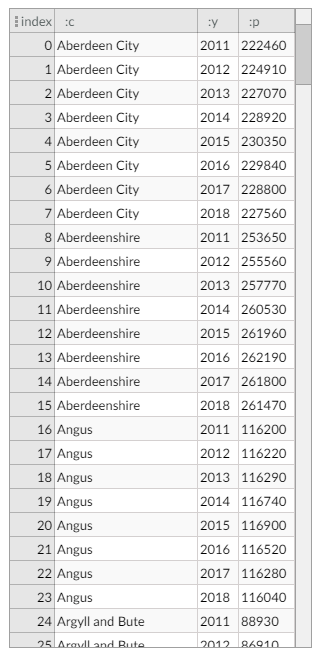

Now let's use the above two SPARQL queries in a single query SPARQL query that will find the waste tonnage genearated per council citizen per year (i.e. be equivalent to the Datalog query that was discussed earlier)...


In [10]:
; Query for the waste tonnage genearated per council citizen per year

(def sparql "

PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX pdmx: <http://purl.org/linked-data/sdmx/2009/dimension#>
PREFIX sdmx: <http://statistics.gov.scot/def/dimension/>
PREFIX snum: <http://statistics.gov.scot/def/measure-properties/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?c ?y ?t2
WHERE {
  
    ?tonnage qb:dataSet <http://statistics.gov.scot/data/household-waste> .
    ?tonnage pdmx:refArea ?area .
    ?tonnage pdmx:refPeriod ?period .
    ?tonnage sdmx:wasteCategory ?wastecategory .
    ?tonnage sdmx:wasteManagement ?wastemanagement .
    ?tonnage snum:count ?t1 .
  
    ?wastecategory rdfs:label \"Total Waste\" .
    ?wastemanagement rdfs:label \"Waste Generated\" .

    ?population qb:dataSet <http://statistics.gov.scot/data/population-estimates-current-geographic-boundaries> .
    ?population pdmx:refArea ?area .
    ?population pdmx:refPeriod ?period .
    ?population sdmx:age <http://statistics.gov.scot/def/concept/age/all> .
    ?population sdmx:sex <http://statistics.gov.scot/def/concept/sex/all> .
    ?population snum:count ?p .

    ?area rdfs:label ?c .
    ?period rdfs:label ?y .
    BIND((xsd:integer(?t1)/xsd:integer(?p)) AS ?t2) .
}
")

(def tonnage-generated-per-council-citizen-per-year (exec-query sparql))

(sort-by (juxt :c :y) tonnage-generated-per-council-citizen-per-year)

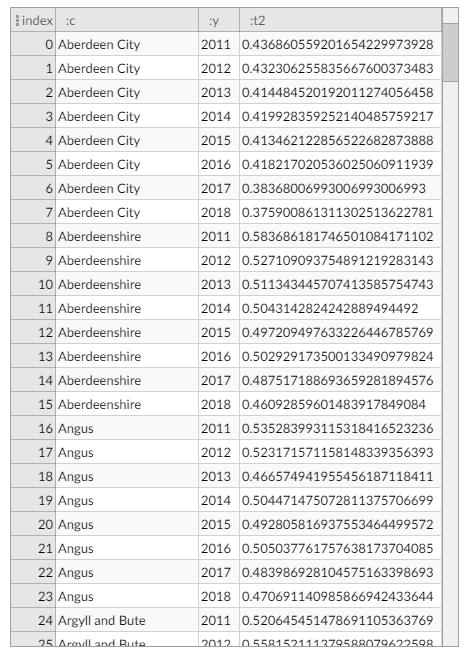

Now let's put that data into an infographic...


In [11]:
; Plot an info-graphic the waste tonnage genearated per council citizen per year

(def lines
    (->> tonnage-generated-per-council-citizen-per-year
        (group-by :c)
        (map (fn [[c coll1]]
                (let [coll2 (sort-by :y coll1)]
                    {:label c
                     :x-series (->> coll2 
                         (map :y) 
                         (map (fn [yyyy] (LocalDate/parse (str yyyy "-12-31")))))
                     :y-series (->> coll2
                         (map :t2))})))))

(def time-plot
    (doto (TimePlot.)
        (.setTitle "Waste generated per council-citizen per year")
        (.setXLabel "Year")
        (.setYLabel "Tonnage")))
(doseq [line lines]
    (.add time-plot (doto (Line.)
                        (.setDisplayName (:label line))
                        (.setX (:x-series line))
                        (.setY (:y-series line)))))
time-plot

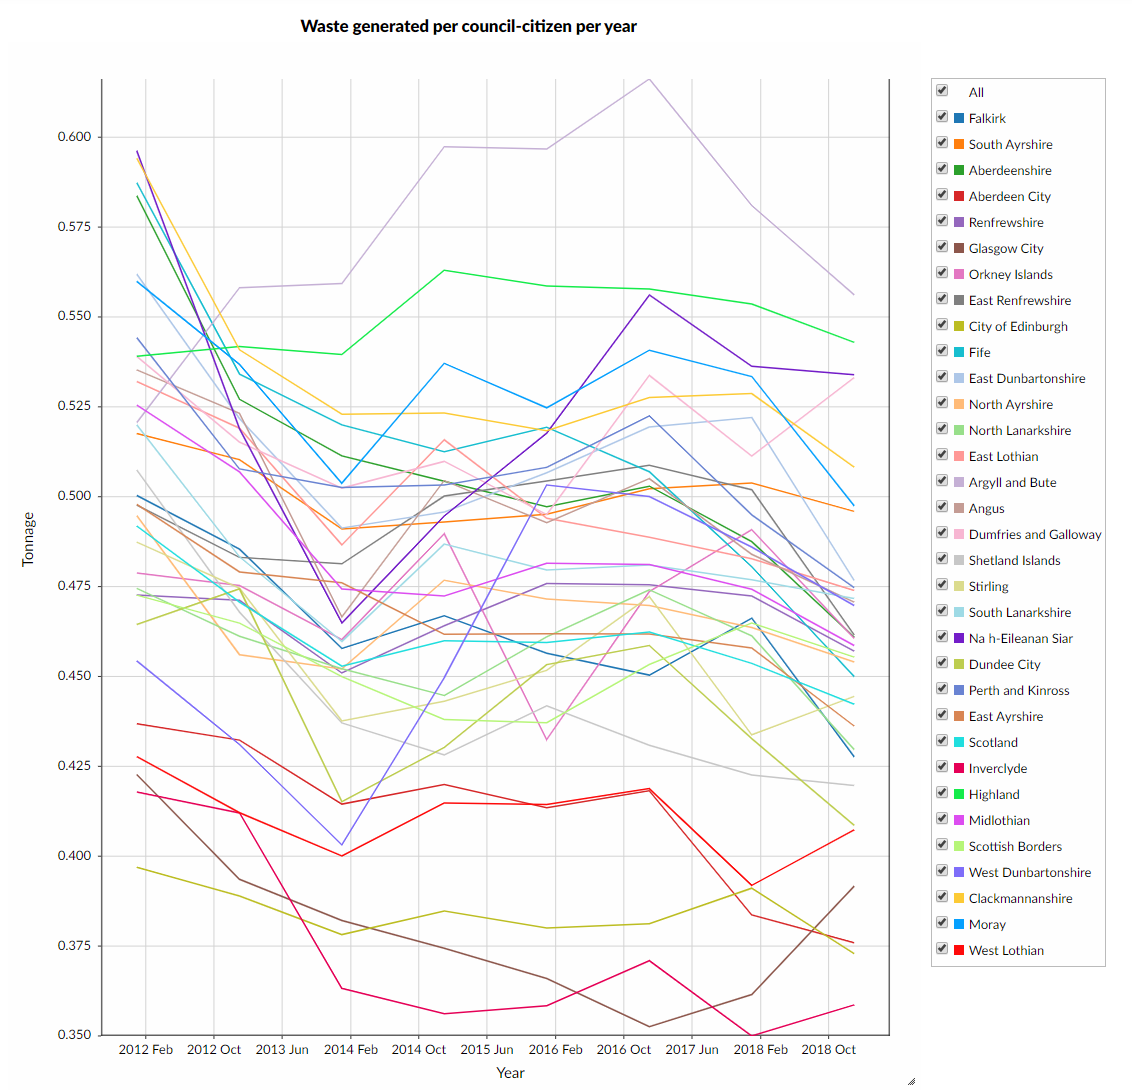

#### Conclusions

* I'm impressed at statistics.gov.scot's platform - it manages to curate, link and make accessible a sizeable number of datasets from several sources.  
Its datasets include some (e.g. [Household Waste](https://statistics.gov.scot/data/household-waste) and [Population](https://statistics.gov.scot/data/population-estimates-current-geographic-boundaries)) that are core to providing data about waste in Scotland.

* Its SPARQL interface is powerful and has shown itself to be useful. 
However, some care must be taken to ensure that queries against it, are performant.   
For example, we might have to split one query (requiring many _joins_) into several smaller queries (requiring less _joins_) that are neading together outside of SPARQL.

* For the general public, statistics.gov.scot is not "easy to use" - I have seen several references to this in Slack workspaces (OpenDataScotland and SODU).    
Whereas, statistictions/coders may accept that it is reasonably simple given that it is neading together diverse datasets into a coherent knowledge.   
(Certainly it has taken me over one work-day to understand enough about the structures within statistics.gov.scot, just to be able to construct the queries above.)   
One of the objectives of the Data Commons Scotland project is to address this "easy of use" issue.
